In [1]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

from lcapt.analysis import make_feature_grid
from lcapt.lca import LCAConv2D
from lcapt.metric import compute_l1_sparsity, compute_l2_error

In [2]:
BATCH_SIZE = 64
EPOCHS = 20
FEATURES = 64  # number of dictionary features to learn
KERNEL_SIZE = 9  # height and width of each feature
LAMBDA = 0.25  # LCA threshold
PRINT_FREQ = 10
STRIDE = 2  # convolutional stride
TAU = 200  # LCA time constant

In [ ]:
dset = CIFAR10('./data', download=True, transform=ToTensor())
dataloader = DataLoader(dset, BATCH_SIZE, shuffle=True, num_workers=4)

In [4]:
lca = LCAConv2D(
    n_neurons=FEATURES,
    in_c=3,
    result_dir='./cifar_dictionary_learning',
    kh=KERNEL_SIZE,
    kw=KERNEL_SIZE,
    stride_h=STRIDE,
    stride_w=STRIDE,
    lambda_=LAMBDA,
    tau=TAU,
    return_all=True,
    track_metrics=False
)
if torch.cuda.is_available():
    lca = torch.nn.DataParallel(lca).cuda()

In [ ]:
for epoch in range(EPOCHS):
    for batch_num, (images, _) in enumerate(dataloader):
        code, recon, recon_error, _, _ = lca(images)
        lca.module.update_weights(code, recon_error)
        if batch_num % PRINT_FREQ == 0:
            l1_sparsity = compute_l1_sparsity(code, lca.module.lambda_).item()
            l2_recon_error = compute_l2_error(recon_error + recon, recon).item()
            total_energy = l2_recon_error + l1_sparsity
            print(f'L2 Recon Error: {round(l2_recon_error, 2)}; ',
                  f'L1 Sparsity: {round(l1_sparsity, 2)}; ',
                  f'Total Energy: {round(total_energy, 2)}')
    torch.save(lca, f'save_{epoch}.pth')

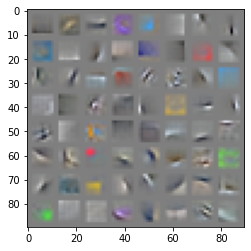

In [8]:
weight_grid = make_feature_grid(lca.module.get_weights())
plt.imshow(weight_grid.cpu().numpy())

Text(0.5, 1.0, 'Reconstruction')

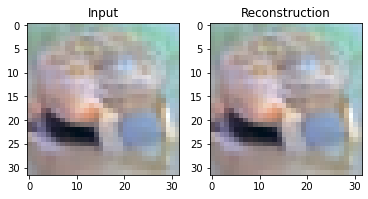

In [21]:
fig, ax = plt.subplots(1, 2)
recon = recon[0].cpu().numpy().transpose(1, 2, 0)
recon_error = recon_error[0].cpu().numpy().transpose(1, 2, 0)
inputs = (recon_error + recon)
recon = (recon - recon.min()) / (recon.max() - recon.min())
inputs = (inputs - inputs.min()) / (inputs.max() - inputs.min())
img1 = ax[0].imshow(recon)
img2 = ax[1].imshow(recon)
ax[0].set_title('Input')
ax[1].set_title('Reconstruction')